In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.autograd as autograd
import torch.nn as nn
import solver2 as solver

2nd differential equation (damped) harmonic oscillator
$$
f''(t) + c f'(t) + k^2 f(t) = 0
$$
for $t \in [0,\infty)$. General solution is
$$
f(t) = e^{-ct/2}[C_1 \cos (\omega t) + C_2 \sin (\omega t)], \ \omega = \sqrt{k^2 - c^2/4}
$$
Note $c^2 < 4k^2$ (check this?) means underdamped, $c^2 = 4 k^2$ means critically damped, and $c^2 > 4k^2$ means overdamped harmonic oscillator. Below pick 
$$
c = -1, \ k = 2
$$
initial conditions
$$
f(0) = 0, \ f'(0) = 1
$$
Analytical solution simplifies then to
$$
f(t) = \frac{4}{3\sqrt{7}} e^{-t/4} \sin \left( \frac{3\sqrt{7}}{4} t  \right)
$$

In [17]:
# Set-up the problem, define the loss function, and number of training points

def differential(t, f):
    t = t.requires_grad_(True)
    ft = f(t)
    Dft = autograd.grad(ft, t, grad_outputs=torch.ones_like(ft), create_graph=True)[0]
    D2ft = autograd.grad(Dft, t, grad_outputs=torch.ones_like(Dft), create_graph=True)[0]
    return D2ft + 0.5*Dft + 4*ft

def bc1(t0, f):
    # f(t0) = 0
    ft = f(t0)
    return ft

def bc2(t0 ,f):
    # f'(t0) = 1
    t0 = t0.requires_grad_(True)
    ft = f(t0)
    Dt_ft = autograd.grad(ft, t0,grad_outputs=torch.ones_like(ft), create_graph=True)[0]
    return Dt_ft - 1.0

tlow, thigh = 0.0, 10.0
num_points = 100
domain = torch.linspace(tlow, thigh, num_points).reshape(-1,1)
domain = domain[1:] # Ignore boundary domain value used at the b.c. term

t0 = torch.tensor([0.0]).reshape(-1,1)
bc_tuples = [(bc1, t0), (bc2, t0)]

loss_fn = solver.LossFunction(differential, bc_tuples)

# Define the model, other hyperparameters
model = nn.Sequential(
    nn.Linear(1,10),
    nn.Tanh(),
    nn.Linear(10,100),
    nn.Tanh(),
    nn.Linear(100,1),
)

class Sine(nn.Module):
    def forward(self, x):
        return torch.sin(x)

model_sine = nn.Sequential(
    nn.Linear(1,10),
    Sine(),
    nn.Linear(10,10),
    nn.Tanh(),
    nn.Linear(10,1),
)

epochs = 20000
lr = 0.001

# Training
# print("Training model with no sine activation")
# loss_data = solver.train(model, loss_fn, domain, epochs, lr, batch_size=32, print_progress=True, print_progress_percentage=0.1)
loss_data = None

print("Training model with sine activation")
loss_data_sine = solver.train(model_sine, loss_fn, domain, epochs, lr, batch_size=50, print_progress=True, print_progress_percentage=0.1, use_scheduler=True, scheduler_factor=0.01, scheduler_patience=500)

Training model with sine activation
Epoch 2000/20000 (10.0%) Loss: 0.00010481072240509093
Epoch 4000/20000 (20.0%) Loss: 4.666580935008824e-05
Epoch 6000/20000 (30.0%) Loss: 4.028564944746904e-06
Epoch 8000/20000 (40.0%) Loss: 5.99894792685518e-06
Epoch 10000/20000 (50.0%) Loss: 4.7657663344580214e-06
Epoch 12000/20000 (60.0%) Loss: 4.50542302132817e-06
Epoch 14000/20000 (70.0%) Loss: 3.896815542248078e-06
Epoch 16000/20000 (80.0%) Loss: 3.698340833580005e-06
Epoch 18000/20000 (90.0%) Loss: 3.834536983049475e-06
Epoch 20000/20000 (100.0%) Loss: 3.4146708003390813e-06


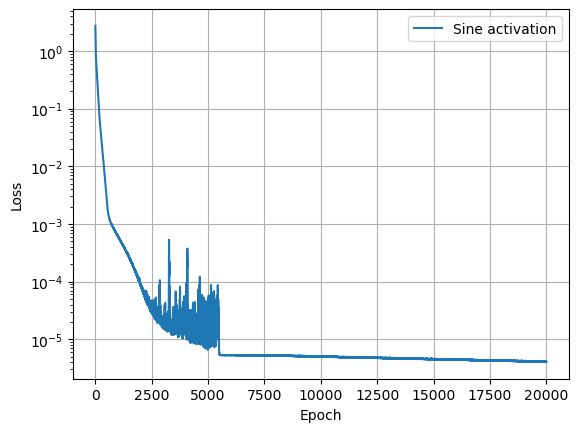

In [18]:
# plt.plot(loss_data, label='No sine acivation')
plt.plot(loss_data_sine, label='Sine activation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid()
plt.show()

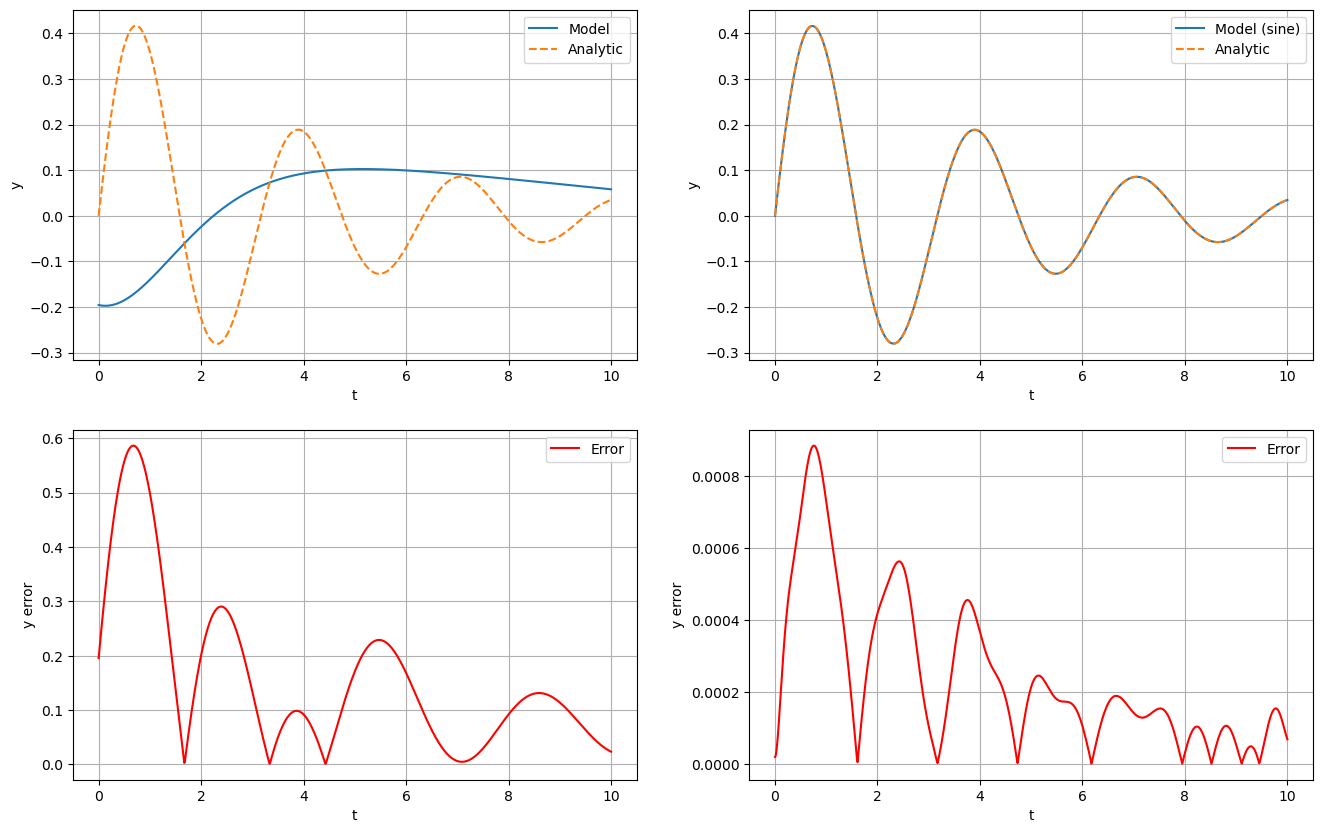

In [19]:
def analytic(t):
    a = 4 / (3 * np.sqrt(7))
    return a * np.exp(-t/4) * np.sin((1/a) * t)

num_test = 1000
t_test_tensor = torch.linspace(tlow, thigh, num_test).reshape(-1,1)

model_test = model(t_test_tensor)
y_model_test = model_test.detach().numpy().reshape(-1)

model_sine_test = model_sine(t_test_tensor)
y_model_sine_test = model_sine_test.detach().numpy().reshape(-1)

t_test = t_test_tensor.numpy()
y_analytic_test = analytic(t_test).reshape(-1)


# Plot and error plot

# Plots of model without sine activation
fig, ax = plt.subplots(2, 2, figsize=(16, 10))

ax[0,0].plot(t_test, y_model_test, label="Model")
ax[0,0].plot(t_test, y_analytic_test, label="Analytic", linestyle='--')
ax[0,0].set_xlabel("t")
ax[0,0].set_ylabel("y")
ax[0,0].legend()
ax[0,0].grid(True)

y_error = np.abs(y_model_test - y_analytic_test)
ax[1,0].plot(t_test, y_error, label="Error", color='red')
ax[1,0].set_xlabel("t")
ax[1,0].set_ylabel("y error")
ax[1,0].legend()
ax[1,0].grid(True)

ax[0,1].plot(t_test, y_model_sine_test, label="Model (sine)")
ax[0,1].plot(t_test, y_analytic_test, label="Analytic", linestyle='--')
ax[0,1].set_xlabel("t")
ax[0,1].set_ylabel("y")
ax[0,1].legend()
ax[0,1].grid(True)

y_error = np.abs(y_model_sine_test - y_analytic_test)
ax[1,1].plot(t_test, y_error, label="Error", color='red')
ax[1,1].set_xlabel("t")
ax[1,1].set_ylabel("y error")
ax[1,1].legend()
ax[1,1].grid(True)

plt.savefig("harmonic-ode-sols.png")

plt.show()